In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

sys.path.append(r"C:\Users\mikek\OneDrive\Project\DLS\DLS-git")
onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
from code_comparison.solps_pp import *

from DLScommonTools import *
from Morph import *
from Postprocess import *

%matplotlib inline
set_matplotlib_defaults()

%load_ext autoreload
%autoreload 2

# Here are some useful labels to use for plotting throughout notebook
store_labels = dict()
store_labels["cvar"] = {"density" : "$n_{u}\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}$"}
store_labels["crel"] = {"density" : "$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ /\ q_{\parallel0} (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

store_names =         {"density" : "$n_{u}\ /\ n_{u0}$",
                        "power" : "$q_{\parallel0}\ /\ q_{\parallel}$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

store_cnames =         {"density" : "$[n_{u}\ /\ n_{u0}]^{1}$",
                        "power" : "$[q_{\parallel0}\ /\ q_{\parallel}]^{5/7}$",
                        "impurity_frac" : "$[f_{z}\ /\ f_{z0}]^{0.5}$"}


st40_phys_viewer can not be loaded from outside Tokamak Energy!



# Read balance file

In [2]:
balance_path = r"C:\Users\mikek\OneDrive\Project\DLS\from_stuart\2023-07-11 - SPR45 balance file\balance.nc"
eqb = dict()
eqb["SPR45"] = dict()

for side in ["il", "ol", "iu", "ou"]: # Inner lower, outer lower.
    eqb["SPR45"][side] = unpackConfigurationMK(File = balance_path, Type = side, sepadd=1, resolution = 200)
    
    keys = list(eqb["SPR45"][side].keys())
    for key in keys:
        
        if key not in ["Bpol", "Btot", "Xpoint", "Spol", "S", "R", "Z"]:
            eqb["SPR45"][side].pop(key, None)
        
file_write(eqb, "equilibrium.pkl")

In [3]:
eqb = file_read("equilibrium.pkl")
data = eqb["SPR45"] # Pick design to use for study

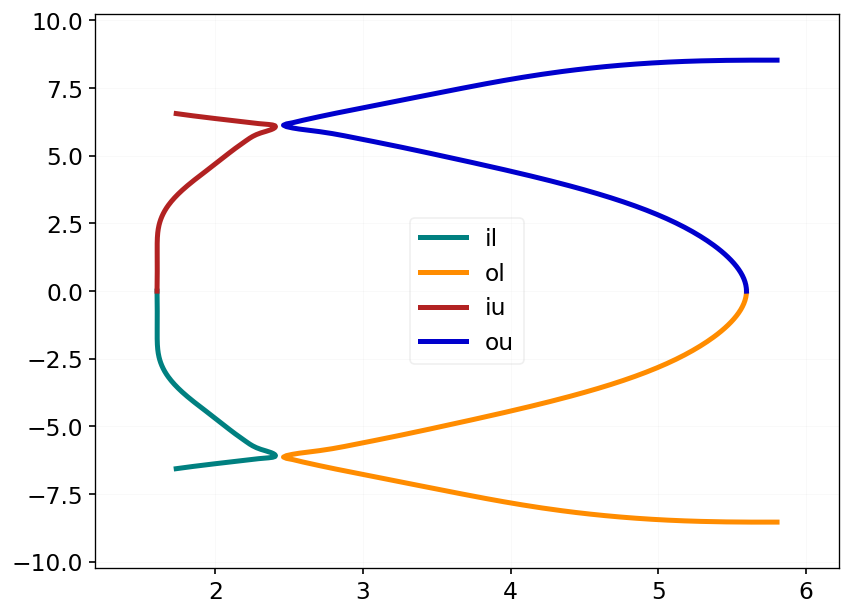

In [47]:
fig, ax = plt.subplots()
for side in ["il", "ol", "iu", "ou"]:
    ax.plot(data[side]["R"], data[side]["Z"], label = side)
    
ax.legend()

# Setup and run DLS

In [4]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # WIP - do not use. if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5, # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, # Upstream density (if constant)
    "nu0" : 1e20, # Upstream density (if constant)
    "cz0" : 0.02, # Impurity fraction (if constant)
    
    "Lfunc": LfuncKallenbachAr, # impurity cooling function. More are available in AnalyticCoolingCurves.py
    "alpha": 1000, # WIP - do not use. flux limiting alpha. Only matters if fluxlim is true
}

# Morph1: Move inner target down to outer target level

In [5]:
%matplotlib inline

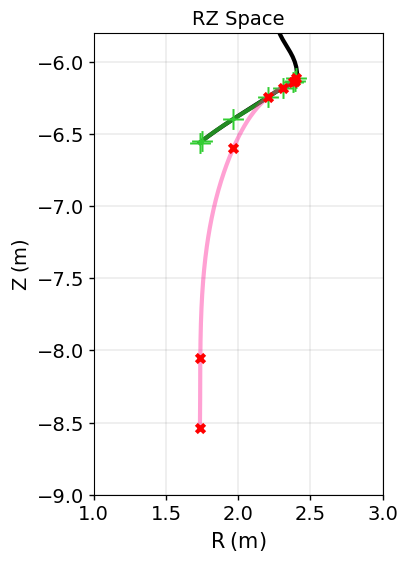

In [7]:
plt.close("all")

d = eqb["SPR45"]["il"]
morph1 = Morph(d["R"], d["Z"], d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])
morph1.set_start_profile(
    [
    {"pos" : 1},
    {"pos" : 0.97},
    {"pos" : 0.95},
    {"pos" : 0.85},
    {"pos" : 0.7},
    {"pos" : 0.35},
    {"pos" : 0.02},
    {"pos" : 0.0},
    ]
)

morph1.set_end_profile(
    [
    {"pos" : 1,     "offsety": 0},
    {"pos" : 0.97,  "offsety": 0},
    {"pos" : 0.95,  "offsety": 0},
    {"pos" : 0.85,  "offsety": 0},
    {"pos" : 0.7,   "offsety": 0},
    {"pos" : 0.35,  "offsety": -0.2},
    {"pos" : 0.02,  "offsety": -1.5, "offsetx": -0.01},
    {"pos" : 0.0,   "offsety": -1.98},
    ]
)

morph1.profs = morph1.generate_profiles(np.linspace(0,1,5))
morph1.plot_profile(morph1.end, xlim = (1, 3), ylim = (-9, -5.8))

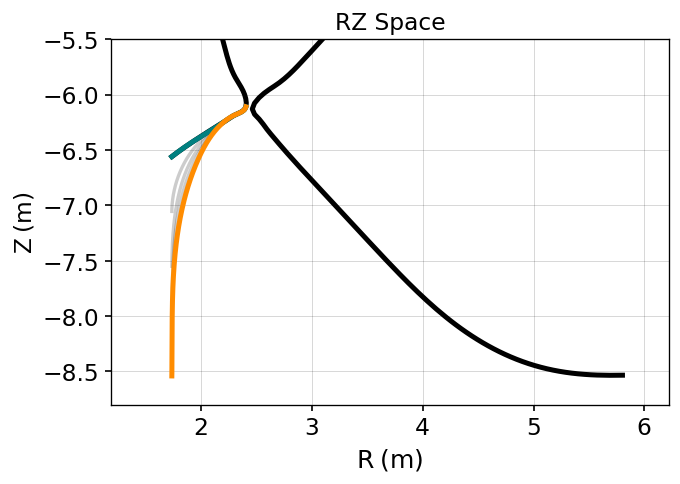

In [8]:

fig, ax = plt.subplots(1, figsize = (6,12))
morph = morph1
profs = {}
for p in morph.profiles:
    prof = morph.profiles[p]
    ax.plot(prof["xs"], prof["ys"], c = "black", zorder = 100, alpha = 0.2, lw = 2, ls = "-")

s = morph.start
e = morph.end
d_outer = eqb["SPR45"]["ol"]
ax.plot(morph.R, morph.Z, linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)
ax.plot(d_outer["R"], d_outer["Z"], linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)
ax.plot(s["xs"], s["ys"], c = "teal", zorder = 100, alpha = 1)
ax.plot(e["xs"], e["ys"], c = "darkorange", zorder = 100, alpha = 1)
ax.set_xlabel("$R\ (m)$", fontsize = 15)
ax.set_ylabel("$Z\ (m)$")
ax.set_ylim(-8.8, -5.5)

alpha = 0.5
ax.set_title("RZ Space")
ax.grid(alpha = 0.3, color = "k")
ax.set_aspect("equal")

In [9]:
morph1.plot_profile_check(morph1.end)

TypeError: Morph.plot_profile_check() missing 1 required positional argument: 'prof2'

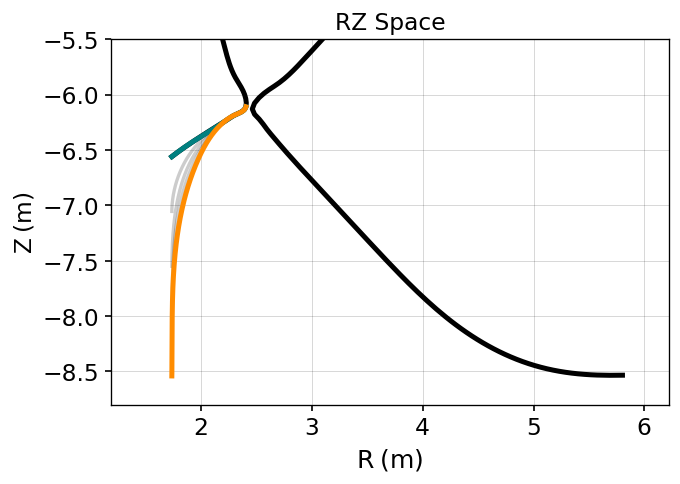

In [10]:

fig, ax = plt.subplots(1, figsize = (6,12))
morph = morph1
profs = {}
for p in morph.profiles:
    prof = morph.profiles[p]
    ax.plot(prof["xs"], prof["ys"], c = "black", zorder = 100, alpha = 0.2, lw = 2, ls = "-")

s = morph.start
e = morph.end
d_outer = eqb["SPR45"]["ol"]
ax.plot(morph.R, morph.Z, linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)
ax.plot(d_outer["R"], d_outer["Z"], linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)
ax.plot(s["xs"], s["ys"], c = "teal", zorder = 100, alpha = 1)
ax.plot(e["xs"], e["ys"], c = "darkorange", zorder = 100, alpha = 1)
ax.set_xlabel("$R\ (m)$", fontsize = 15)
ax.set_ylabel("$Z\ (m)$")
ax.set_ylim(-8.8, -5.5)

alpha = 0.5
ax.set_title("RZ Space")
ax.grid(alpha = 0.3, color = "k")
ax.set_aspect("equal")

In [11]:
cvar = "density"
design = "SPR45"
side = "iu"

store1 = dict()
# for cvar in ["power"]:
for cvar in ["density"]:
    
    for p in morph1.profiles:
        d = morph1.profiles[p].copy()

        # d = eqb[design][side].copy() # Load in single profile into dictionary "d"
        constants = constants_default.copy() # Set settings to default
        radios = radios_default.copy() # Set settings to default
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 10) # Solve at these parallel positions

        if "i" in side:
            constants["qpllu0"] = constants_default["qpllu0"] * 1.1 # Reduce power to 10% for the inner divertor to account for power sharing.

        results = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = cvar, Ctol = 1e-3, Ttol=1e-3)
        
        store1[p] = copy.deepcopy(results)

Solving...0...4...9...12...15...18...19...20...21...22...Complete in 19.5 seconds
Solving...0...4...8...12...15...17...19...20...21...22...Complete in 21.8 seconds
Solving...0...4...8...12...15...17...19...20...21...22...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Complete in 20.4 seconds
Solving...0...5...9...12...15...17...19...20...21...22...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Complete in 20.7 seconds
Solving...0...5...9...12...15...17...19...20...21...22...Complete in 22.4 seconds


# Stage 2: move further away from centre column

In [ ]:
%matplotlib inline

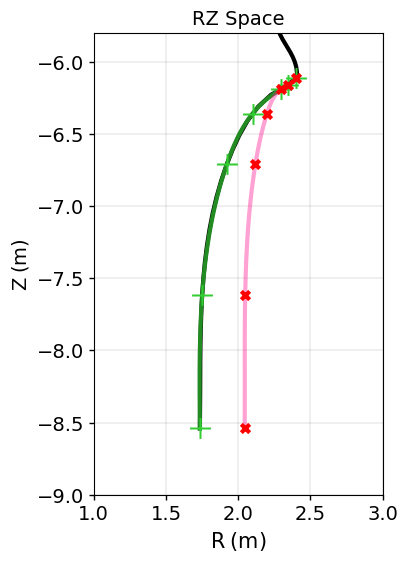

In [12]:
plt.close("all")

# d = eqb["SPR45"]["iu"]
d = morph1.profiles[1].copy()
morph2 = Morph(d["R"], d["Z"], d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])
morph2.set_start_profile(
    [
    {"pos" : 1},
    {"pos" : 0.97},
    {"pos" : 0.95},
    {"pos" : 0.85},
    {"pos" : 0.7},
    {"pos" : 0.35},
    {"pos" : 0.0},
    ]
)

morph2.set_end_profile(
    [
    {"pos" : 1,     "offsetx": 0},
    {"pos" : 0.97,  "offsetx": 0},
    {"pos" : 0.95,  "offsetx": 0},
    {"pos" : 0.85,  "offsetx": 0.1},
    {"pos" : 0.7,   "offsetx": 0.198},
    {"pos" : 0.35,  "offsetx": 0.298},
    {"pos" : 0.0,   "offsetx": 0.31},
    ]
)

morph2.profs = morph2.generate_profiles(np.linspace(0,1,5))
morph2.plot_profile(morph2.end, xlim = (1, 3), ylim = (-9, -5.8))

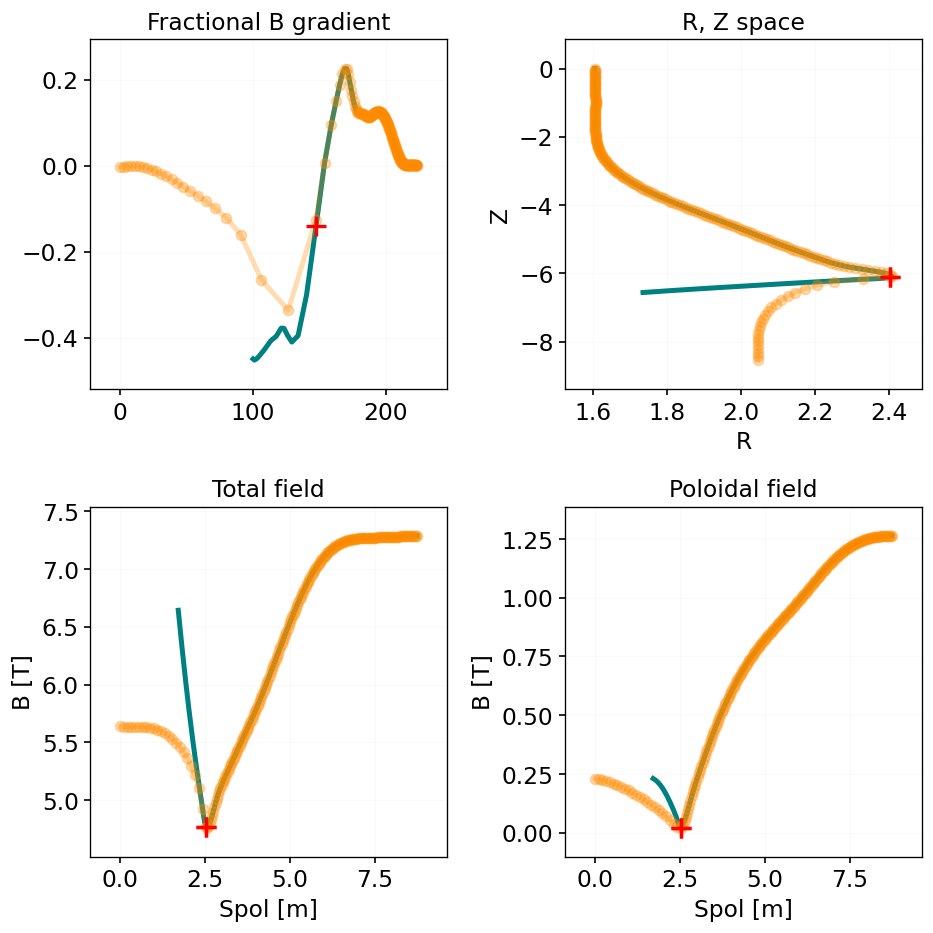

In [13]:
morph2.plot_profile_check(morph1.start, morph2.end)

In [14]:
store2 = dict()
# for cvar in ["power"]:
for cvar in ["density"]:

    
    for p in morph2.profiles:
        d = morph2.profiles[p].copy()

        constants = constants_default.copy() # Set settings to default
        radios = radios_default.copy() # Set settings to default
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 10) # Solve at these parallel positions

        if "i" in side:
            constants["qpllu0"] = constants_default["qpllu0"] * 1.1 # Reduce power to 10% for the inner divertor to account for power sharing.

        results = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = cvar, Ctol = 1e-3, Ttol=1e-3)
        
        store2[p] = copy.deepcopy(results)

Solving...0...5...9...12...15...17...19...20...21...22...Complete in 21.0 seconds
Solving...0...5...9...12...15...17...19...20...21...22...Complete in 22.1 seconds
Solving...0...5...9...12...15...18...19...20...21...22...Complete in 22.8 seconds
Solving...0...5...9...13...15...18...19...20...21...22...Complete in 19.9 seconds
Solving...0...5...9...13...16...18...19...20...21...22...Complete in 20.4 seconds


# Post-process

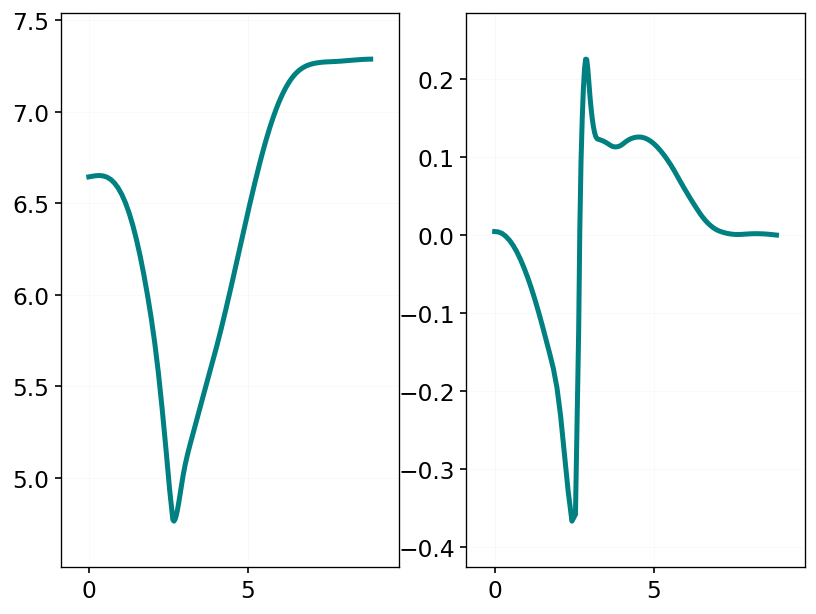

In [168]:
p = morph2.profiles[0]


fig, axes= plt.subplots(1,2)

ax = axes[0]
ax.plot(p["Spol"], p["Btot"])

ax = axes[1]
ax.plot(p["Spol"], np.gradient(p["Btot"], p["Spol"]) / p["Btot"])

avg_frac_gradB = ((np.gradient(p["Btot"], p["Spol"]) / p["Btot"])[:p["Xpoint"]]).mean()

In [240]:
store.keys()

dict_keys(['density', 0.0, 0.25, 0.5, 0.75, 1.0])

In [30]:

morph = morph1
store = store1
target_sens = [morph.get_sensitivity(store[x]["crel_trim"], store[x]["SpolPlot"], fluctuation=1.1, location=0) for x in morph.profiles]

target_sens

[0, 0, 0, 0, 0]

Spol at location: 0.389
Crel at location: -2797.340
Sensitivity: 0.000


0

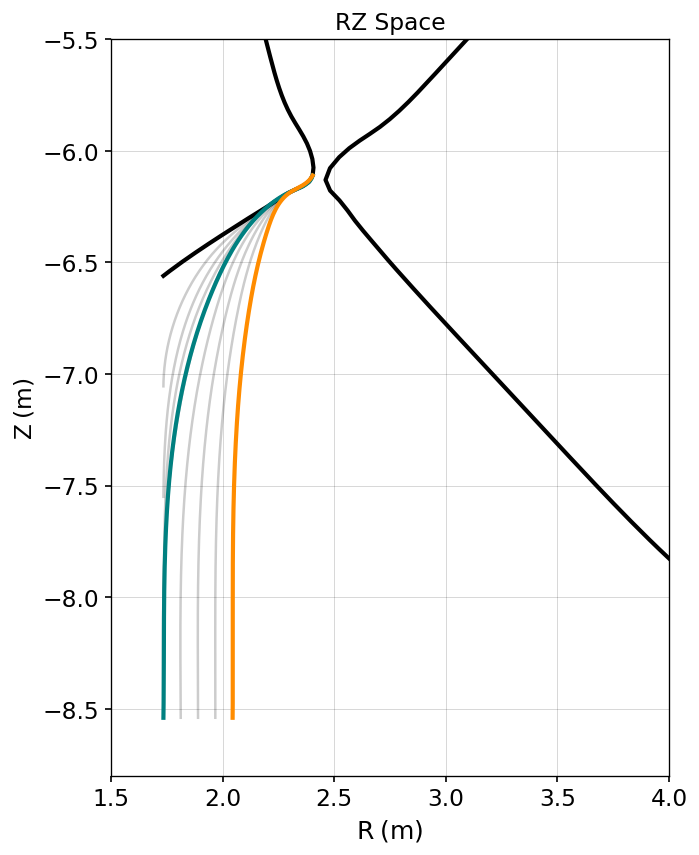

In [15]:
fig, ax = plt.subplots(1, figsize = (6,12))
morph = morph1
for p in morph.profiles:
    prof = morph.profiles[p]
    ax.plot(prof["xs"], prof["ys"], c = "black", zorder = 100, alpha = 0.2, lw = 1.5, ls = "-")
    
morph = morph2
for p in morph.profiles:
    prof = morph.profiles[p]
    ax.plot(prof["xs"], prof["ys"], c = "black", zorder = 100, alpha = 0.2, lw = 1.5, ls = "-")

s = morph.start
e1 = morph1.end 
e2 = morph2.end

style = dict(linewidth = 2.5)

d_outer = eqb["SPR45"]["ol"]
d_inner = eqb["SPR45"]["il"]
# ax.plot(morph.R, morph.Z, linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)
ax.plot(d_inner["R"], d_inner["Z"], color = "black", alpha = 1, **style)
ax.plot(d_outer["R"], d_outer["Z"], color = "black", alpha = 1, **style)

ax.plot(e1["xs"], e1["ys"], c = "teal", zorder = 100, alpha = 1, **style)
ax.plot(e2["xs"], e2["ys"], c = "darkorange", zorder = 100, alpha = 1, **style)
ax.set_xlabel("$R\ (m)$", fontsize = 15)
ax.set_ylabel("$Z\ (m)$")
ax.set_xlim(1.5,4.0)
ax.set_ylim(-8.8, -5.5)

alpha = 0.5
ax.set_title("RZ Space")
ax.grid(alpha = 0.3, color = "k")
ax.set_aspect("equal")

## Plot topology changes

In [84]:
S_xpoint_max = max([p["S"][p["Xpoint"]] for p in profiles])

S_xpoint_max

165.8582463360237

In [87]:
p["S"][p["Xpoint"]]

147.35885933779164

In [133]:
Spol_shift_base

1.8295832215713719

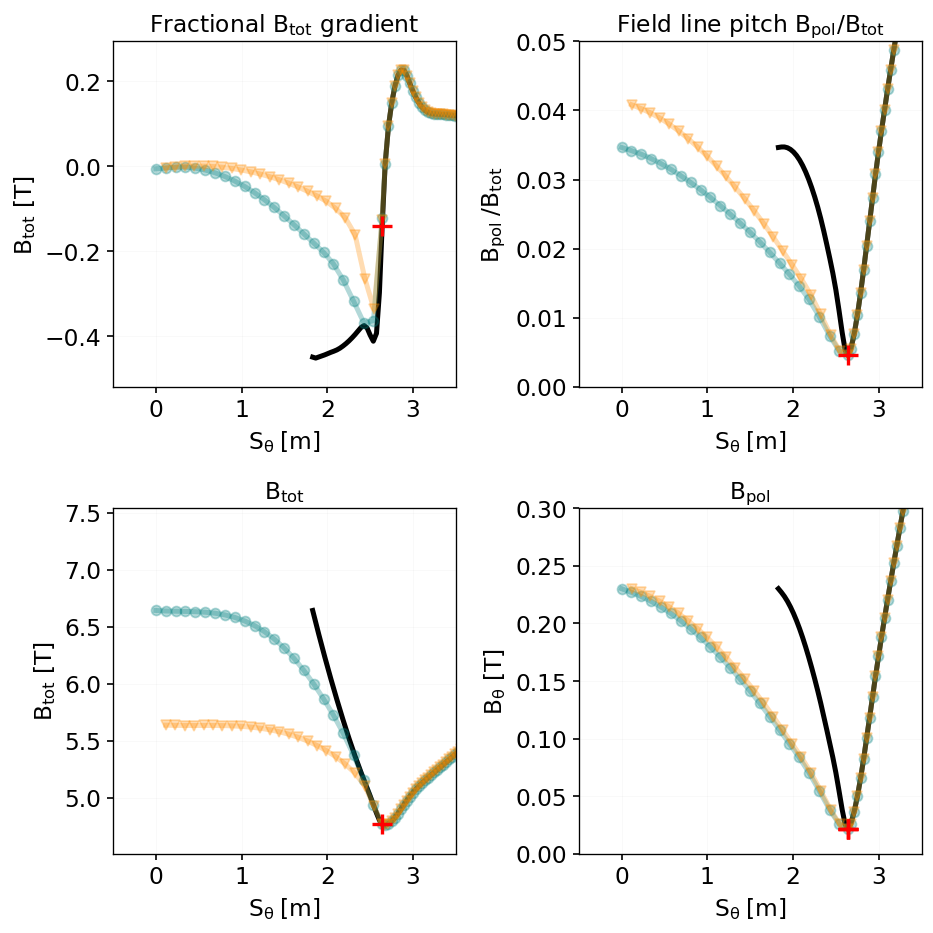

In [193]:


def plot_profile_topology(base_profile, profiles):

    fig, axes = plt.subplots(2,2, figsize = (8,8))
    markers = ["o", "v"]

    profstyle = dict(alpha = 0.3)

    basestyle = dict(c = "black")
    xstyle = dict(marker = "+", linewidth = 2, s = 150, c = "r", zorder = 100)

    S_xpoint_max = max([p["S"][p["Xpoint"]] for p in profiles])
    S_pol_xpoint_max = max([p["Spol"][p["Xpoint"]] for p in profiles])

    Spol_shift_base = S_pol_xpoint_max - d["Spol"][d["Xpoint"]] 



    ax = axes[0,0]
    ax.set_title("Fractional $B_{tot}$ gradient")

    ax.plot(d["Spol"] + Spol_shift_base, np.gradient(d["Btot"], d["Spol"]) / d["Btot"], **basestyle)
    ax.scatter(d["Spol"][d["Xpoint"]] + Spol_shift_base, (np.gradient(d["Btot"], d["Spol"]) / d["Btot"])[d["Xpoint"]], **xstyle)
    for i, p in enumerate(profiles): 
        Spol_shift = S_pol_xpoint_max  - p["Spol"][p["Xpoint"]]
        ax.plot(p["Spol"] + Spol_shift, np.gradient(p["Btot"], p["Spol"]) / p["Btot"], **profstyle, marker = markers[i])
        # ax.scatter(p["Spol"][p["Xpoint"]]+ Spol_shift, (np.gradient(p["Btot"], p["Spol"]) / p["Btot"])[p["Xpoint"]], **xstyle)
        ax.set_xlabel(r"$S_{\theta} \   [m]$");   
        ax.set_ylabel("$B_{tot}$ $[T]$")


    ax = axes[1,0]
    ax.set_title("$B_{tot}$")

    ax.plot(d["Spol"] + Spol_shift_base, d["Btot"], **basestyle)
    ax.scatter(d["Spol"][d["Xpoint"]] + Spol_shift_base, d["Btot"][d["Xpoint"]], **xstyle)
    for i, p in enumerate(profiles): 
        Spol_shift = S_pol_xpoint_max  - p["Spol"][p["Xpoint"]]
        ax.plot(p["Spol"] + Spol_shift, p["Btot"], **profstyle, marker = markers[i])
        ax.set_xlabel(r"$S_{\theta} \   [m]$")
        ax.set_ylabel("$B_{tot}$ $[T]$")


    ax = axes[0,1]

    ax.set_title(r"Field line pitch $B_{pol}/B_{tot}$")
    ax.plot(d["Spol"] + Spol_shift_base, d["Bpol"]/d["Btot"], **basestyle)
    ax.scatter(d["Spol"][d["Xpoint"]]+ Spol_shift_base, (d["Bpol"]/d["Btot"])[d["Xpoint"]], **xstyle)
    for i, p in enumerate(profiles): 
        Spol_shift = S_pol_xpoint_max  - p["Spol"][p["Xpoint"]]
        ax.plot(p["Spol"] + Spol_shift, p["Bpol"]/p["Btot"], **profstyle, marker = markers[i])
    ax.set_xlabel(r"$S_{\theta} \   [m]$")
    ax.set_ylabel(r"$B_{pol} \ / B_{tot}$ ")
    ax.set_ylim(0,0.05)

    ax = axes[1,1]
    ax.set_title("$B_{pol}$")

    ax.plot(d["Spol"] + Spol_shift_base, d["Bpol"], **basestyle)
    ax.scatter(d["Spol"][d["Xpoint"]] + Spol_shift_base,  (d["Bpol"])[d["Xpoint"]], **xstyle)
    for i, p in enumerate(profiles): 
        Spol_shift = S_pol_xpoint_max  - p["Spol"][p["Xpoint"]]
        ax.plot(p["Spol"] + Spol_shift, p["Bpol"], **profstyle, marker = markers[i])
        ax.scatter(p["Spol"][p["Xpoint"]] + Spol_shift,  (p["Bpol"])[p["Xpoint"]], **xstyle)
    ax.set_ylim(0,0.3)
    ax.set_xlabel(r"$S_{\theta} \   [m]$")
    ax.set_ylabel(r"$B_{\theta}$ $[T]$")

    for ax in [axes[0,0], axes[1,0], axes[0,1], axes[1,1]]:
        ax.set_xlim(-0.5,3.5)

    fig.tight_layout()
    
plot_profile_topology(morph1.profiles[0], [morph1.profiles[1], morph2.profiles[1]])

In [31]:
BxBt

array([0.71804421, 0.71804421, 0.71804421, 0.71804421, 0.71804421])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


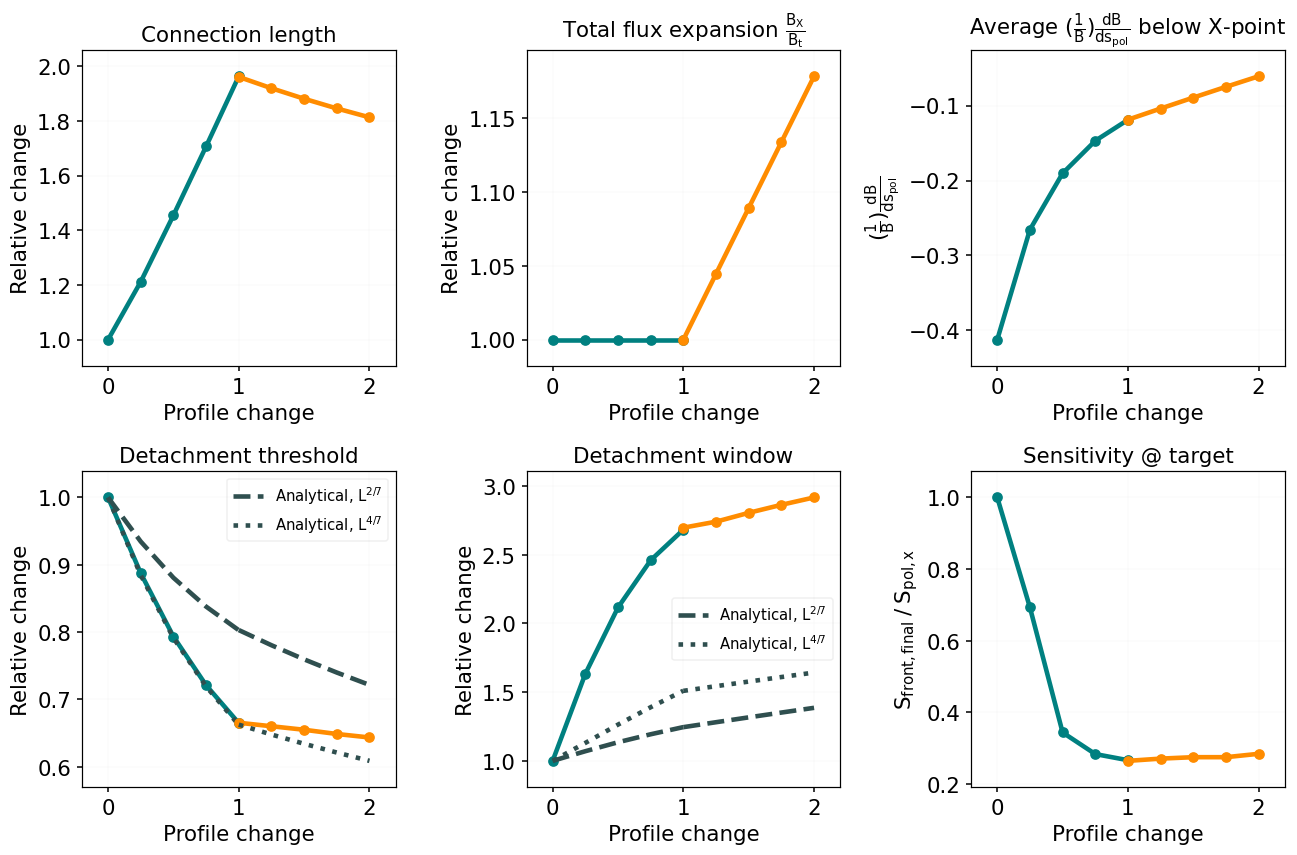

In [192]:
labels = ["Height", "Height and distance"]
colors = ["teal", "darkorange"]
stores = [store1, store2]

windows = []

fig, axes = plt.subplots(2,3, dpi = 110, figsize = (12,8))

for i, morph in enumerate([morph1, morph2]):
    
    

    store = stores[i]
    windows = np.array([store[x]["window"] for x in morph.profiles])
    thresholds = np.array([store[x]["threshold"] for x in morph.profiles])
    L = np.array([morph.get_connection_length(morph.profiles[x]) for x in morph.profiles])
    BxBt = np.array([morph.get_total_flux_expansion(morph.profiles[x]) for x in morph.profiles])
    frac_gradB = np.array([morph.get_average_frac_gradB(morph.profiles[x]) for x in morph.profiles])
    avgB_ratio = np.array([morph.get_average_B_ratio(morph.profiles[x]) for x in morph.profiles])
    
    target_sens = np.array([morph.get_sensitivity(store[x]["crel_trim"], store[x]["SpolPlot"], fluctuation=1.05, location=0.0) for x in morph.profiles])
    
    if i == 0:
        L_base = L[0]
        BxBt_base = BxBt[0]
        threshold_base = thresholds[0]
        window_base = windows[0]
        avgB_ratio_base = avgB_ratio[0]
        
    threshcalc = (BxBt/BxBt_base)**(-1) * (L/L_base)**(-2/7) * (avgB_ratio/avgB_ratio_base)**(2/7)
    threshcalc2 = (BxBt/BxBt_base)**(-1) * (L/L_base)**(-4/7) * (avgB_ratio/avgB_ratio_base)**(2/7)
    
    windowcalc = (BxBt/BxBt_base)**(1) * (L/L_base)**(2/7) * (avgB_ratio/avgB_ratio_base)**(-2/7)
    windowcalc2 = (BxBt/BxBt_base)**(1) * (L/L_base)**(4/7) * (avgB_ratio/avgB_ratio_base)**(-2/7)
    
    index = np.linspace(0,1,5)+i
    
    
    
    index = np.linspace(0,1,5)+i
    axes[0,0].set_title("Connection length")
    axes[0,0].plot(index, L/L_base, marker = "o")
    
    axes[0,1].set_title(r"Total flux expansion $\frac{B_{X}}{B_{t}}$")
    axes[0,1].plot(index, BxBt/BxBt_base, marker = "o")
    
    axes[0,2].set_title(r"Average $(\frac{1}{B}) \frac{dB}{ds_{pol}}$ below X-point")
    axes[0,2].plot(index, frac_gradB, marker = "o")
    
    axes[1,0].set_title(r"Detachment threshold")
    axes[1,0].plot(index, thresholds/threshold_base, marker = "o")
    
    axes[1,0].plot(index, threshcalc, color = "darkslategrey", ls = "--", label = None if i == 0 else "Analytical, $L^{2/7}$")
    axes[1,0].plot(index, threshcalc2, color = "darkslategrey", ls = ":", label = None if i == 0 else "Analytical, $L^{4/7}$")
    axes[1,0].legend(fontsize = "x-small")
    
    axes[1,1].set_title(r"Detachment window")
    axes[1,1].plot(index, windows/window_base, marker = "o")
    axes[1,1].plot(index, windowcalc, color = "darkslategrey", ls = "--", label = None if i == 0 else "Analytical, $L^{2/7}$")
    axes[1,1].plot(index, windowcalc2, color = "darkslategrey", ls = ":", label = None if i == 0 else "Analytical, $L^{4/7}$")
    axes[1,1].legend(fontsize = "x-small")
    
    axes[1,2].set_title(r"Sensitivity @ target")
    axes[1,2].plot(index, target_sens, marker = "o")

for ax in axes.flatten():
    ax.set_xlabel("Profile change")

for ax in [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]:
    ax.set_ylabel("Relative change")
    
axes[0,2].set_ylabel(r"$(\frac{1}{B}) \frac{dB}{ds_{pol}}$")
axes[1,2].set_ylabel("$S_{front, final} \ /\  S_{pol, x}$")
fig.tight_layout()

In [25]:
target_sens

[None, None, None, None, None]

In [16]:
cases = dict(base = store1[0], stage1 = store1[1], stage2 = store2[1])

In [46]:
morph.get_sensitivity(store1[0]["crel_trim"], store1[0]["SpolPlot"], fluctuation=1.1, location=0.0, verbose = True)

Spol at location: 0.000
Crel at location: 0.793
Sensitivity: 0.000


0

## Front profiles

C:\Users\mikek\AppData\Local\Temp\ipykernel_61524\3747345689.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('winter', 5)
C:\Users\mikek\AppData\Local\Temp\ipykernel_61524\3747345689.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('Wistia', 5)


Text(0.5, 1.0, 'Front position response to upstream density')

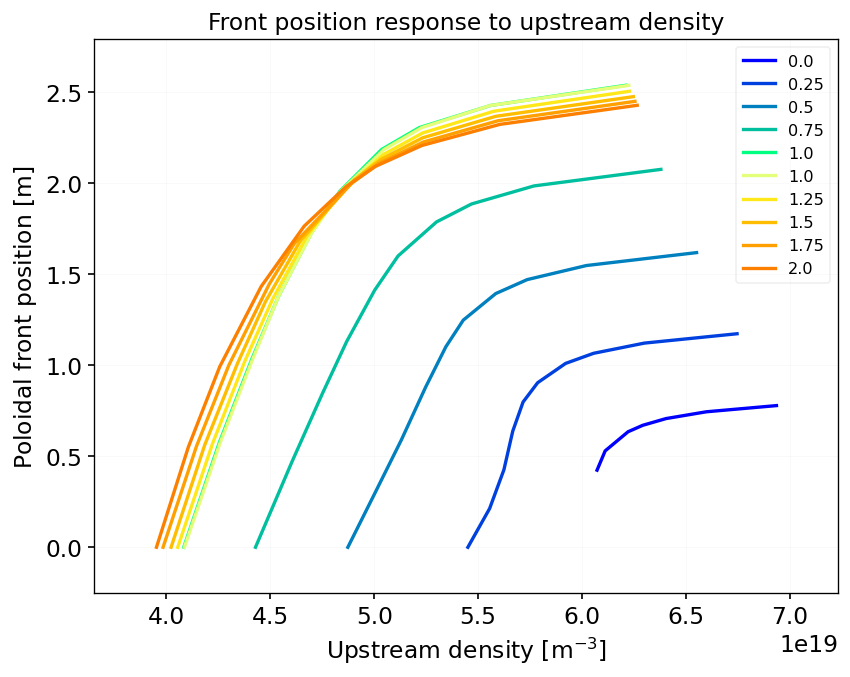

In [78]:
s = store1[0]

s.keys()

fig, ax = plt.subplots()
style = dict(lw = 2)
cmap = mpl.cm.get_cmap('winter', 5)
colors = [cmap(x) for x in np.linspace(0,1, len(morph1.profiles))]
for i, store in enumerate(morph1.profiles):
    s = store1[store]

    ax.plot(s["cvar_trim"], s["SpolPlot"], label = store, color = colors[i], **style)
    
    
cmap = mpl.cm.get_cmap('Wistia', 5)
colors = [cmap(x) for x in np.linspace(0,1, len(morph1.profiles))]
for i, store in enumerate(morph2.profiles):
    s = store2[store]

    ax.plot(s["cvar_trim"], s["SpolPlot"], label = store+1, color = colors[i], **style)
    
ax.legend(fontsize = "x-small", loc = "upper right")
ax.set_xlabel("Upstream density $[m^{-3}]$")
ax.set_ylabel("Poloidal front position $[m]$")
ax.set_title("Front position response to upstream density")
# store2.keys()

## Topology gradients

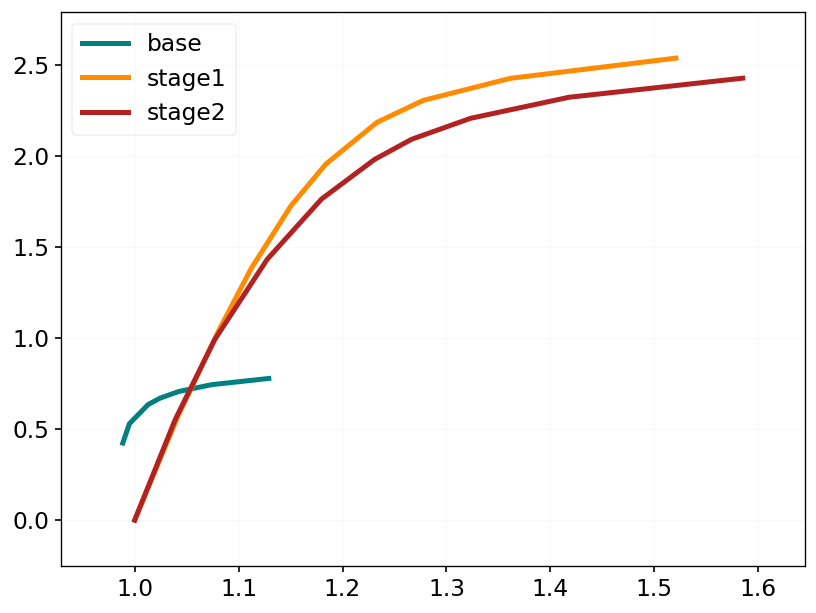

In [248]:
s = store1[0]

s.keys()

fig, ax = plt.subplots()

for name in cases:
    s = cases[name]
    ax.plot(s["crel_trim"], s["SpolPlot"], label = name)
    
ax.legend()

# store2.keys()

In [ ]:
store2[0].keys()

thresholds = [store2[x]["threshold"] for x in morph2.profiles]
windows = [store2[x]["window"] for x in morph2.profiles]

fig, axes = plt.subplots(2,2, dpi = 100, figsize = (10,10))

labels = ["Height", "Height and distance"]
colors = ["teal", "darkorange"]
stores = [store1, store2]

for i, morph in enumerate([morph1, morph2]):

    store = stores[i]
    windows = [store[x]["window"] for x in morph.profiles]
    thresholds = [store[x]["threshold"] for x in morph.profiles]
    L = [morph.get_connection_length(morph.profiles[x]) for x in morph.profiles]
    BxBt = [morph.get_total_flux_expansion(morph.profiles[x]) for x in morph.profiles]
    
    bwidths = []
    for x in morph.profiles:
        _, width = get_band_widths(morph.profiles[x], store[x], cvar = "density", size = 0.05)
        bwidths.append(np.nanmean(width))
    sens = 1/np.array(bwidths)
    
    # sens = []
    
    # for j in store:
    #     if j != "density":
    #         o = store[j]
    #         sens.append(np.mean(np.gradient(store[j]["SpolPlot"],  store[j]["crel_trim"])))
        
    x = np.array(range(len(morph.profiles)))+1
    
    styles = dict(label = labels[i], c = colors[i])

    ax = axes[0,0]
    ax.set_title("Connection length improvement")
    ax.plot(x, L / L[0], **styles)

    ax = axes[0,1]
    ax.set_title("Total flux exp. improvement")
    ax.plot(x, BxBt / BxBt[0], **styles)

    ax = axes[1,0]
    ax.set_title("Window improvement")
    ax.plot(x, windows / windows[0], **styles)
    
    ax = axes[1,1]
    ax.set_title(r"Average 5% sensitivity")
    ax.plot(x, sens, **styles)

# windows = [store2[x]["window"] for x in morph2.profiles]
# ax.plot(windows / windows[0], label = "Morph 2")
# ax.plot(thresholds[0] / thresholds[0])
    for ax in axes.flatten():
        ax.legend(fontsize = "small")
        ax.set_xlabel("Extent of change")
        ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(6))

fig.tight_layout()

# OLD MORPH 2

# Morph2: move inner target lower and also inwards

In [ ]:
d["R"]

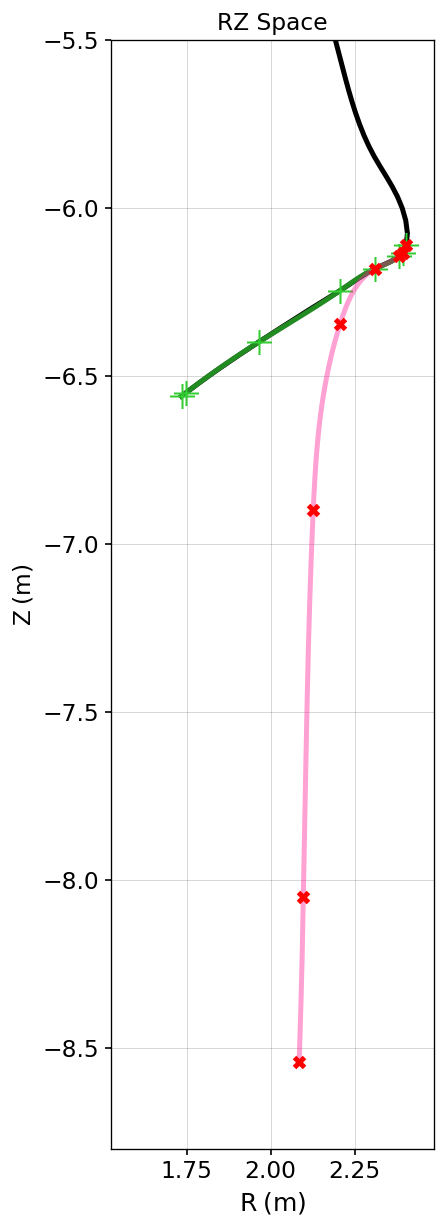

In [6]:
d = eqb["SPR45"]["iu"]
morph2 = Morph(d["R"], d["Z"]*-1, d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])
morph2.set_start_profile(
    [
    {"pos" : 1},
    {"pos" : 0.97},
    {"pos" : 0.95},
    {"pos" : 0.85},
    {"pos" : 0.7},
    {"pos" : 0.35},
    {"pos" : 0.02},
    {"pos" : 0.0},
    ]
)

morph2.set_end_profile(
    [
    {"pos" : 1,     "offsetx" : 0, "offsety": 0},
    {"pos" : 0.97,  "offsetx" : 0, "offsety": 0},
    {"pos" : 0.95,  "offsetx" : 0, "offsety": 0},
    {"pos" : 0.85,  "offsetx" : 0, "offsety": 0},
    {"pos" : 0.7,   "offsetx" : 0, "offsety": -0.1},
    {"pos" : 0.35,  "offsetx" : 0.16, "offsety": -0.5},
    {"pos" : 0.02,  "offsetx" : 0.35, "offsety": -1.5},
    {"pos" : 0.0,   "offsetx" : 0.35, "offsety": -1.98},
    ]
)

morph2.profs = morph2.generate_profiles(np.linspace(0,1,5))

morph2.plot_profile(morph2.end)


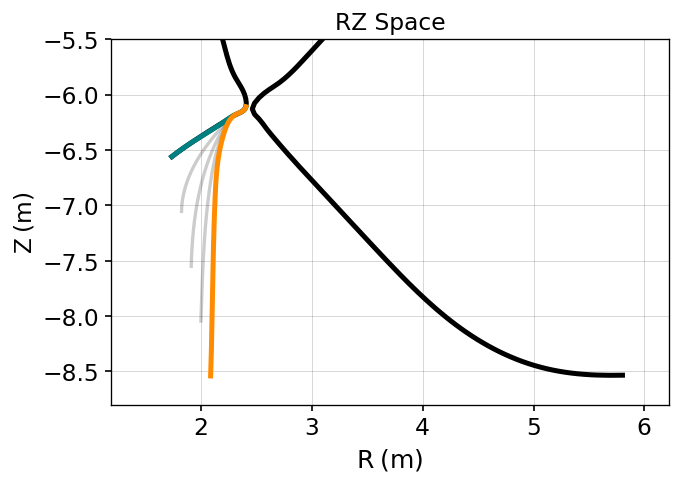

In [11]:

fig, ax = plt.subplots(1, figsize = (6,12))
morph = morph2
profs = {}
for p in morph.profiles:
    prof = morph.profiles[p]
    ax.plot(prof["xs"], prof["ys"], c = "black", zorder = 100, alpha = 0.2, lw = 2, ls = "-")

s = morph.start
e = morph.end
d_outer = eqb["SPR45"]["ou"]
ax.plot(morph.R, morph.Z, linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)
ax.plot(d_outer["R"], d_outer["Z"]*-1, linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)
ax.plot(s["xs"], s["ys"], c = "teal", zorder = 100, alpha = 1)
ax.plot(e["xs"], e["ys"], c = "darkorange", zorder = 100, alpha = 1)
ax.set_xlabel("$R\ (m)$", fontsize = 15)
ax.set_ylabel("$Z\ (m)$")
ax.set_ylim(-8.8, -5.5)

alpha = 0.5
ax.set_title("RZ Space")
ax.grid(alpha = 0.3, color = "k")
ax.set_aspect("equal")

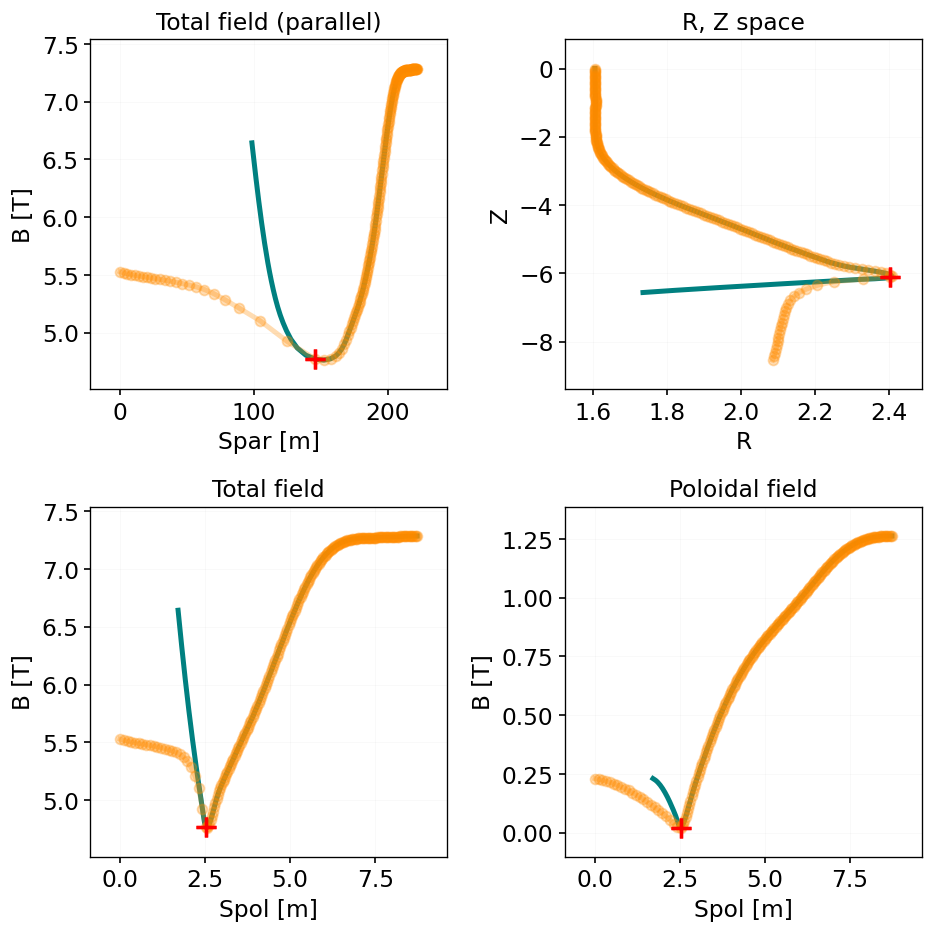

In [12]:
morph2.plot_profile_check(morph2.end)

In [10]:
cvar = "density"
design = "SPR45"
side = "iu"

store2 = dict()
# for cvar in ["power"]:
for cvar in ["density"]:
    store2[cvar] = dict()
    
    for p in morph2.profiles:
        d = morph2.profiles[p].copy()

        constants = constants_default.copy() # Set settings to default
        radios = radios_default.copy() # Set settings to default
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 10) # Solve at these parallel positions

        if side == "iu":
            constants["qpllu0"] = constants_default["qpllu0"] * 1.1 # Reduce power to 10% for the inner divertor to account for power sharing.

        results = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = cvar, Ctol = 1e-3, Ttol=1e-3)
        
        store2[p] = copy.deepcopy(results)

Solving...0...4...9...12...15...18...19...20...21...22...Complete in 31.1 seconds
Solving...0...5...9...12...15...18...19...20...21...22...Complete in 29.5 seconds
Solving...0...5...9...12...15...18...19...20...21...22...Complete in 33.6 seconds
Solving...0...5...9...13...16...18...19...20...21...22...Complete in 33.2 seconds
Solving...0...5...9...13...16...18...19...21...22...Complete in 25.9 seconds


In [95]:
axes.flatten()

array([<Axes: title={'center': 'Connection length improvement'}>,
       <Axes: title={'center': 'Total flux exp. improvement'}>, <Axes: >,
       <Axes: >], dtype=object)

In [115]:
o["crel"]

array([1.        , 1.03450738, 1.43437768])

In [128]:
np.nanmean(get_band_widths(morph1.profiles[1], store2[1], cvar = "density", size = 0.05))

0.4192855694488488

In [201]:
for i in store:
    print(store[i].keys())

dict_keys([])
dict_keys(['Splot', 'SpolPlot', 'cvar', 'Rprofiles', 'logs', 'spar_onset', 'spol_onset', 'splot', 'indexRange', 'crel', 'cvar_trim', 'crel_trim', 'threshold', 'window', 'window_ratio', 'constants', 'radios', 'state'])
dict_keys(['Splot', 'SpolPlot', 'cvar', 'Rprofiles', 'logs', 'spar_onset', 'spol_onset', 'splot', 'indexRange', 'crel', 'cvar_trim', 'crel_trim', 'threshold', 'window', 'window_ratio', 'constants', 'radios', 'state'])
dict_keys(['Splot', 'SpolPlot', 'cvar', 'Rprofiles', 'logs', 'spar_onset', 'spol_onset', 'splot', 'indexRange', 'crel', 'cvar_trim', 'crel_trim', 'threshold', 'window', 'window_ratio', 'constants', 'radios', 'state'])
dict_keys(['Splot', 'SpolPlot', 'cvar', 'Rprofiles', 'logs', 'spar_onset', 'spol_onset', 'splot', 'indexRange', 'crel', 'cvar_trim', 'crel_trim', 'threshold', 'window', 'window_ratio', 'constants', 'radios', 'state'])
dict_keys(['Splot', 'SpolPlot', 'cvar', 'Rprofiles', 'logs', 'spar_onset', 'spol_onset', 'splot', 'indexRange', 'c

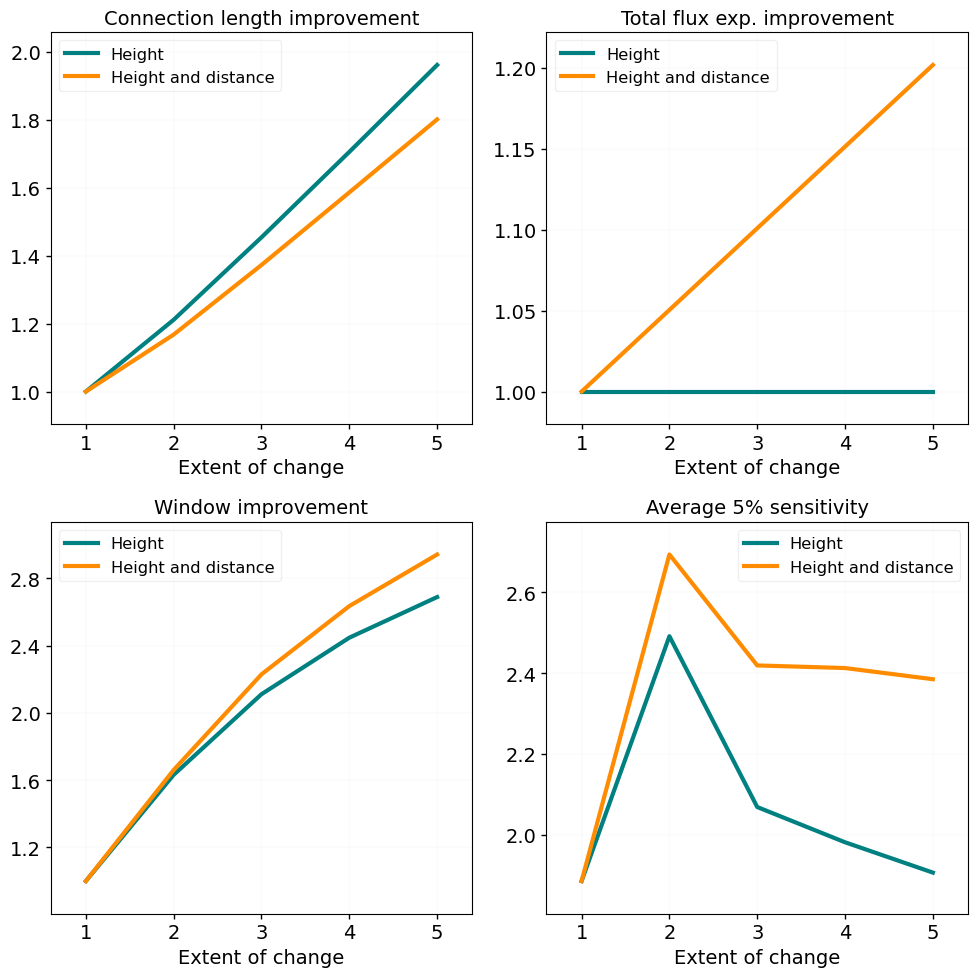

In [17]:
store2[0].keys()

thresholds = [store2[x]["threshold"] for x in morph2.profiles]
windows = [store2[x]["window"] for x in morph2.profiles]

fig, axes = plt.subplots(2,2, dpi = 100, figsize = (10,10))

labels = ["Height", "Height and distance"]
colors = ["teal", "darkorange"]
stores = [store1, store2]

for i, morph in enumerate([morph1, morph2]):

    store = stores[i]
    windows = [store[x]["window"] for x in morph.profiles]
    thresholds = [store[x]["threshold"] for x in morph.profiles]
    L = [morph.get_connection_length(morph.profiles[x]) for x in morph.profiles]
    BxBt = [morph.get_total_flux_expansion(morph.profiles[x]) for x in morph.profiles]
    
    bwidths = []
    for x in morph.profiles:
        _, width = get_band_widths(morph.profiles[x], store[x], cvar = "density", size = 0.05)
        bwidths.append(np.nanmean(width))
    sens = 1/np.array(bwidths)
    
    # sens = []
    
    # for j in store:
    #     if j != "density":
    #         o = store[j]
    #         sens.append(np.mean(np.gradient(store[j]["SpolPlot"],  store[j]["crel_trim"])))
        
    x = np.array(range(len(morph.profiles)))+1
    
    styles = dict(label = labels[i], c = colors[i])

    ax = axes[0,0]
    ax.set_title("Connection length improvement")
    ax.plot(x, L / L[0], **styles)

    ax = axes[0,1]
    ax.set_title("Total flux exp. improvement")
    ax.plot(x, BxBt / BxBt[0], **styles)

    ax = axes[1,0]
    ax.set_title("Window improvement")
    ax.plot(x, windows / windows[0], **styles)
    
    ax = axes[1,1]
    ax.set_title(r"Average 5% sensitivity")
    ax.plot(x, sens, **styles)

# windows = [store2[x]["window"] for x in morph2.profiles]
# ax.plot(windows / windows[0], label = "Morph 2")
# ax.plot(thresholds[0] / thresholds[0])
    for ax in axes.flatten():
        ax.legend(fontsize = "small")
        ax.set_xlabel("Extent of change")
        ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(6))

fig.tight_layout()

In [204]:
sens

[nan,
 8.406618039005583,
 5.869536382011335,
 5.73238537062093,
 6.5914800873508375]

In [159]:
store1[0]["SpolPlot"]

[0.0,
 0.14120788022960215,
 0.31772042746838847,
 0.42360262795722725,
 0.5296731315504942,
 0.6348484234822227,
 0.670232682968884,
 0.7071156921171443,
 0.7443167158541194,
 0.7783571350950951]

In [180]:
r.keys()

dict_keys(['Splot', 'SpolPlot', 'cvar', 'Rprofiles', 'logs', 'spar_onset', 'spol_onset', 'splot', 'indexRange', 'crel', 'cvar_trim', 'crel_trim', 'threshold', 'window', 'window_ratio', 'constants', 'radios', 'state'])

In [187]:
np.mean(np.gradient(r["SpolPlot"],  r["crel_trim"]))

6.5914800873508375

Text(0, 0.5, 'Poloidal distance from target')

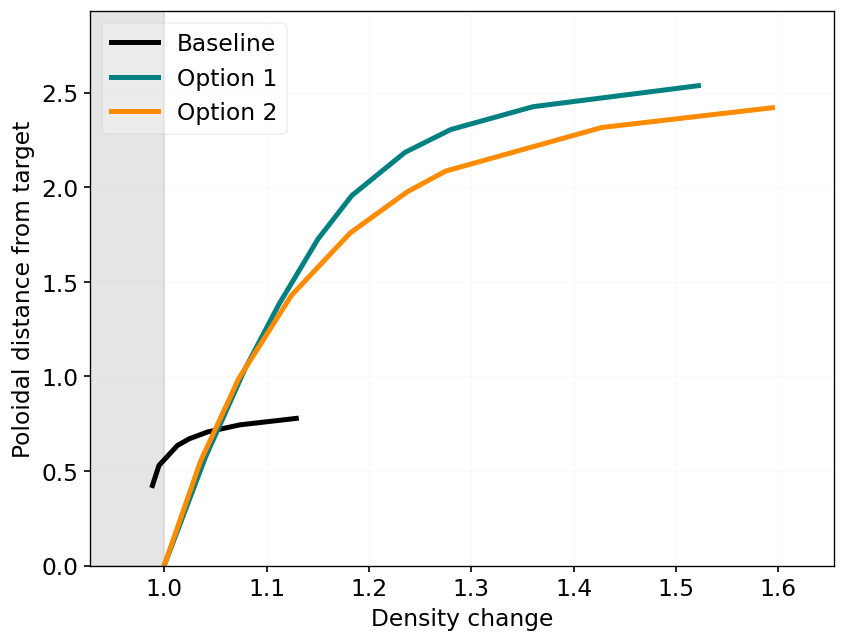

In [18]:
fig, ax = plt.subplots()

r = store1[0]
ax.plot(r["crel_trim"], r["SpolPlot"], label = "Baseline", color = "black")

r = store1[1]
ax.plot(r["crel_trim"], r["SpolPlot"], label = "Option 1", color = "teal")

r = store2[1]
ax.plot(r["crel"], r["SpolPlot"], label = "Option 2", color = "darkorange")

ax.legend()

ylims = ax.get_ylim()
xlims = ax.get_xlim()

ylims = ax.get_ylim()
ylims_new = (0,ylims[1]+ylims[1]*0.05)
ax.set_ylim(ylims_new)
ax.fill_between([xlims[0],1],0,ylims_new[1], color = "grey", alpha = 0.2, label = "Unstable")   
ax.set_xlim(xlims)

ax.set_xlabel("Density change")
ax.set_ylabel("Poloidal distance from target")

Text(0, 0.5, 'Poloidal distance from target')

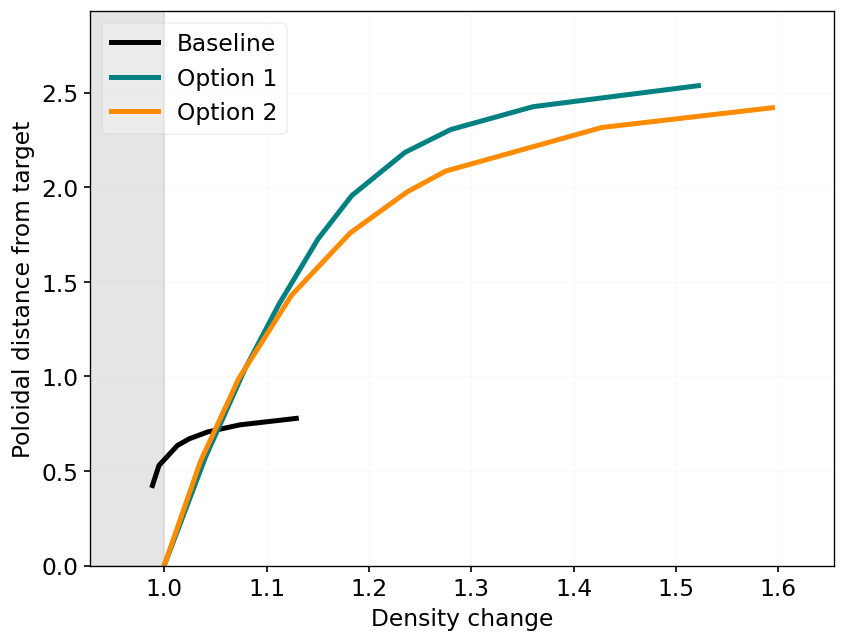

In [12]:
fig, ax = plt.subplots()

r = store1[0]
ax.plot(r["crel_trim"], r["SpolPlot"], label = "Baseline", color = "black")

r = store1[1]
ax.plot(r["crel_trim"], r["SpolPlot"], label = "Option 1", color = "teal")

r = store2[1]
ax.plot(r["crel"], r["SpolPlot"], label = "Option 2", color = "darkorange")

ax.legend()

ylims = ax.get_ylim()
xlims = ax.get_xlim()

ylims = ax.get_ylim()
ylims_new = (0,ylims[1]+ylims[1]*0.05)
ax.set_ylim(ylims_new)
ax.fill_between([xlims[0],1],0,ylims_new[1], color = "grey", alpha = 0.2, label = "Unstable")   
ax.set_xlim(xlims)

ax.set_xlabel("Density change")
ax.set_ylabel("Poloidal distance from target")

density, 0.33
power, 0.33
impurity_frac, 0.33


Text(0, 0.5, 'Band width (m poloidal)')

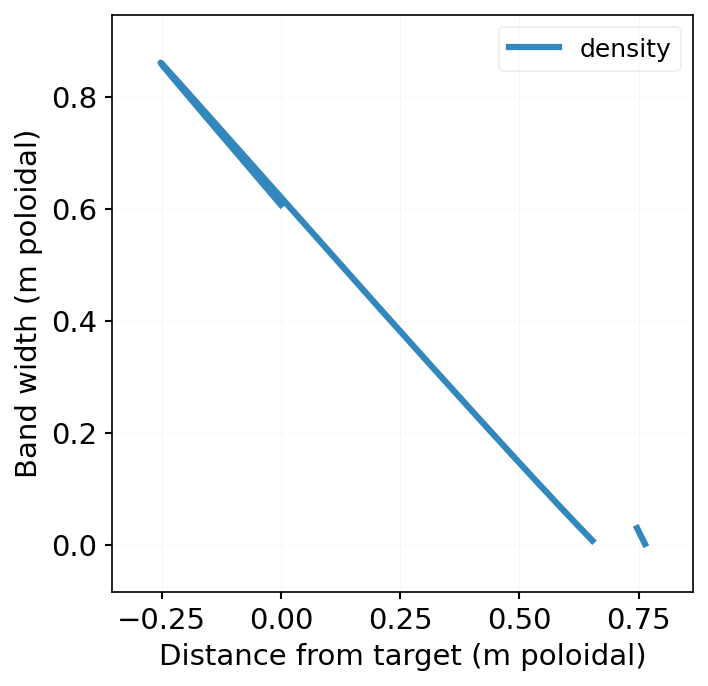

In [171]:
band_widths = {}
size = 0.05
side = "iu"
cvar = "density"
d = morph1.profiles[0]
o = store1[0]

# Find first valid index
# This trims the unstable region on the inner
# trim_idx = 0
# for i,_ in enumerate(o["cvar_trim"]):
#     if pd.isnull(o["cvar_trim"][i]) and not pd.isnull(o["cvar_trim"][i+1]):
#         trim_idx = i+1
    
# Make band based on topology dictionary (d) and results dictionary (o)
# and a desired S poloidal location of the band centre (spol_middle)
# as well as band size as a fraction (default +/-5%)
trim_idx = 0
crel = np.array(o["crel"])[trim_idx:]
splot = np.array(o["Splot"])[trim_idx:]
spolplot = np.array(o["SpolPlot"])[trim_idx:]

if cvar == "power":
    crel = 1/crel

c_grid = np.linspace(crel[0], crel[-1], 1000)
k = 5
spar_interp = interpolate.interp1d(crel, splot, kind="cubic", fill_value = "extrapolate")
spol_interp = interpolate.interp1d(crel, spolplot, kind="cubic", fill_value = "extrapolate")

band_widths = []
for i, c_start in enumerate(c_grid):
    c_middle = c_start/(1-size)
    c_end = c_middle*(1+size)

    spar_start = spar_interp(c_start)
    spar_middle = spar_interp(c_middle)
    spar_end = spar_interp(c_end)

    spol_start = spol_interp(c_start)
    spol_middle = spol_interp(c_middle)
    spol_end = spol_interp(c_end)

    # band_widths.append(s_end - s_start)
    # band_widths.append(interp(c_start/(1-size)*(1+size)) - interp(c_start))
    band_width = spol_end - spol_start
    # band_width = spar_end - spar_start

    if band_width <= 0:
        band_widths.append(np.nan)
    elif spol_end > spolplot[-1]:
        band_widths.append(np.nan)
    else:
        band_widths.append(band_width)



fig, ax = plt.subplots(figsize=(5,5), dpi = 150)
x = spol_interp(c_grid)
ax.plot(x, band_widths, label = "density", color = "#3288bd")


for cvar in ["density", "power", "impurity_frac"]:
    for i, _ in enumerate(x):
        if x[i] > band_widthsb[i]:
            idx = i
            print(f"{cvar}, {x[i]:.2f}")
            break
    # ax.scatter(x[i], band_widths[cvar][i], marker = "x", c = "k", s = 100, zorder = 100)


ax.legend(fontsize = 12)
ax.set_xlabel("Distance from target (m poloidal)")
ax.set_ylabel("Band width (m poloidal)")
    # band_width(2, interp)

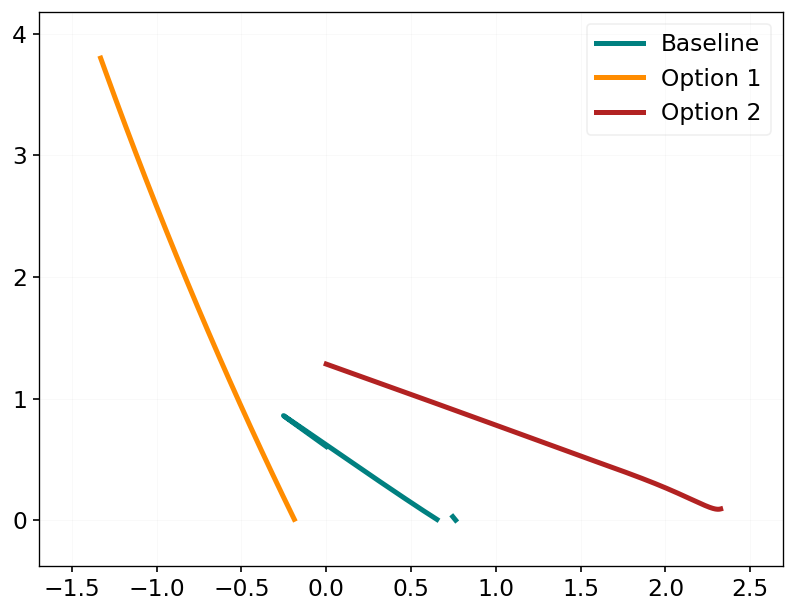

In [167]:

# start = get_band_widths(morph1.profiles[0], store1[0], cvar = "density", size = 0.05)
# opt1 = get_band_widths(morph1.profiles[1], store1[1], cvar = "density", size = 0.05)
# opt2 = get_band_widths(morph2.profiles[1], store2[1], cvar = "density", size = 0.05)

fig, ax = plt.subplots()
dist = store1[0]["SpolPlot"]

morph, store = morph1, store1
x, widths = get_band_widths(morph.profiles[0], store[0], cvar = "density", size = 0.05)
ax.plot(x, widths, label = "Baseline")

morph, store = morph1, store1
x, widths = get_band_widths(morph.profiles[1], store[1], cvar = "density", size = 0.05)
ax.plot(x, widths, label = "Option 1")

morph, store = morph2, store2
x, widths = get_band_widths(morph.profiles[1], store[1], cvar = "density", size = 0.05)
ax.plot(x, widths, label = "Option 2")

ax.legend()